                                    Music Recommendation System

### Preparing of Million Song Dataset

In this notebook, we perform data cleaning and preprocessing of the Million Song Dataset. The dataset contains a vast collection of audio features, metadata, and other information about songs. The cleaning process includes handling missing values, standardizing formats, and filtering out irrelevant data to ensure the dataset is ready for subsequent analysis and recommendation modeling.

The MillionSongDataset can be accessed in its entirety through (http://millionsongdataset.com/pages/getting-dataset/).
    


#### Packages: 

In [109]:
import tables
import h5py
import os
import fnmatch
import sys

import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml.feature import Bucketizer

import findspark
from pyspark.sql import SparkSession, Row
from pyspark import SparkContext
from pyspark.sql.types import *

from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.sql.functions import udf

from pyspark_dist_explore import hist

from pyspark.sql.functions import col, isnan, when, count, sum, mean
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import StringIndexer

import pyspark.sql.functions as F
from pyspark.sql.types import ArrayType, DoubleType
from pyspark.ml.feature import RobustScaler, StandardScaler

import sklearn

from pyspark.sql.functions import row_number, monotonically_increasing_id
from pyspark.sql import Window
from pyspark.sql.window import Window
from pyspark.sql.functions import rank, col, avg, approx_count_distinct
import findspark
from pyspark.conf import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import  countDistinct
from pyspark.sql.functions import avg, lit
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import dense_rank
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline





#### Create spark cluster: 

In [2]:
findspark.init()

conf = SparkConf().setAppName("Songs").setMaster("local[*]") \
    .set("spark.executor.instances", "4").set("spark.executor.cores", "2") \
    .set("spark.executor.memory", "12g").set("spark.driver.memory", "10g")

spark = SparkSession.builder.config(conf=conf).getOrCreate()
sc = spark.sparkContext


#### path to datasets: 

In [3]:
data_MSD_path = 'MillionSongSubset'



####  Read the MSD dataset from HDF5 directories: 
To read the MSD dataset from HDF5 directories, the HDFStore function from the pandas library is utilized. It enables the reading of each .h5 file and storing the data in a PySpark dataframe. Each file contains three keys: '/analysis/songs/', '/metadata/songs/', and '/musicbrainz/songs/'. These keys provide access to the data and metadata stored within the dataset.


#### Load the data in parallel with the help of spark RDD 

####  Extracting desirable features: 
Following columns are chosen to be used in this project. 

In [4]:
attribs=['song_id',
        'title', 
        'artist_id', 
        'duration',
        'key', 
        'loudness',
        'mode',
        'tempo',
        'time_signature',
        'song_hotttnesss', 
        'artist_hotttnesss', 
        'artist_familiarity', 
        'year'
       ] 


In [5]:

# This function is used in RDD to read each .h5 file and return a list of string(data of columns)
# f: directory path from spark.wholeTextFiles() function
# d: dataset directory path
def read_h5(f,d):
    # prune the file path is essential here, because the wholeTextFile function returns the absolute path
    hdf = pd.HDFStore(f[f.index(d):],mode ='r', header = False)  # Openning HDFStore to read .h5 file
    
    # The dataset is HDFS file with 3 main key {analysis, metadata, musicbrains} which 'songs' key allow us 
    # to access the data of each song(It should be mentioned that there are)  
    df1 = hdf.get('/analysis/songs/')
    df2 = hdf.get('/metadata/songs/')
    df3 = hdf.get('/musicbrainz/songs/')
    
    hdf.close()                                                  # Closing HDFStore  
    
    # concatenate all columns together in a dataframe and pick our desired features
    df_concat = pd.concat([df1,df2,df3], axis = 1)[attribs] 
    
    # return the result as a list of string to be able to store in rdd
    return df_concat.values.tolist()[0]

In [6]:
# find all path of all files without loading the files
rdd = sc.wholeTextFiles(data_MSD_path+'/*/*/*/*.h5').map(lambda x: read_h5(x[0],data_MSD_path))

In [8]:
rdd.first()

['SOMZWCG12A8C13C480',
 "I Didn't Mean To",
 'ARD7TVE1187B99BFB1',
 218.93179,
 1,
 -11.197,
 0,
 92.198,
 4,
 0.6021199899057548,
 0.4019975433642836,
 0.5817937658450281,
 0]

Createing Spark dataframe from the RDD: 

In [9]:
# creating the schema for spark dataframe 
schema = StructType([
    StructField('song_id', StringType(), True),
    StructField('title', StringType(), True),
    StructField('artist_id', StringType(), True),
    StructField('duration', FloatType(), True),
    StructField('key', IntegerType(), True),
    StructField('loudness', FloatType(), True),
    StructField('mode', IntegerType(), True),
    StructField('tempo', FloatType(), True),
    StructField('time_signature', IntegerType(), True),
    StructField('song_hotttnesss', FloatType(), True),
    StructField('artist_hotttnesss', FloatType(), True),
    StructField('artist_familiarity', FloatType(), True), 
    StructField('year', IntegerType(), True)
])
data_MSD = spark.createDataFrame(rdd, schema)

In [10]:
#distribution of numerical columns
data_MSD.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
song_id,10000,None,None,SOAAAQN12AB01856D3,SOZZWWW12A58A8146A
title,10000,802.5714285714286,962.5782837675865,,Último Desejo
artist_id,10000,None,None,AR009211187B989185,ARZZRK91187B9A5CA5
duration,10000,238.5075185521245,114.13751360673984,1.04444,1819.7677
key,10000,5.2761,3.5540866538668308,0,11
loudness,10000,-10.485668504679204,5.399788230762881,-51.643,0.566
mode,10000,0.6911,0.4620629180252628,0,1
tempo,10000,122.91544865837098,35.184411706471344,0.0,262.828
time_signature,10000,3.5648,1.2662390359365858,0,7


In [11]:
data_MSD.persist()

DataFrame[song_id: string, title: string, artist_id: string, duration: float, key: int, loudness: float, mode: int, tempo: float, time_signature: int, song_hotttnesss: float, artist_hotttnesss: float, artist_familiarity: float, year: int]

In [12]:
# checkpoint
df = data_MSD

# STEPS:

1. Checking Unique Values and Duplicates:
   - Remove Duplicate Rows.
   - Check Unique Values in each column.
   - Check for Duplicates in groups of `song_id`, `artist_id`, and `title` together.

2. Missing Values and Anomalies:
   - Identify Missing Values.
   - Handle Missing Values.
   - Identify Anomalies.

3. Standardization:
   - Standardize Numeric Columns.

4. Indexing String Features.

5. Removing Unimportant Features.

6. Store the Final Dataset.

7. Rephrase the Final Dataset to match the original format.

Remember to adapt these steps to your specific dataset and programming language as needed.

 ### Checking Unique Values and Duplicates:

- Drope Duplicate

In [13]:
# drop duplicates from the DataFrame based on all columns
data_MSD = data_MSD.dropDuplicates()

# Count the number of rows in the DataFrame
data_MSD.count()

10000

- Unique Values

In [14]:
# Collect the unique values of each column
def unique_data(df, columns):
    unique = [df.select(x).distinct().count() for x in columns]

    # Print the unique values for each column
    total = df.count()
    print(f"Number of unique values for each column, \nthe total count is {total}\n ")

    for i in range(len(columns)):
        print(columns[i], unique[i])

In [15]:
columns = data_MSD.columns
unique_data(data_MSD, columns)

Number of unique values for each column, 
the total count is 10000
 
song_id 10000
title 9709
artist_id 3888
duration 6553
key 12
loudness 7435
mode 2
tempo 9336
time_signature 6
song_hotttnesss 1919
artist_hotttnesss 3713
artist_familiarity 4026
year 69


- Checking Duplicate in Group of song_id, artist_id and title together:

In [16]:
# Calculate the count of distinct combinations of song_id and title
song_title_count = data_MSD.groupBy('song_id', 'title').count().count()

# Calculate the count of distinct combinations of song_id and artist_id
song_artist_count = data_MSD.groupBy('song_id', 'artist_id').count().count()

# Print the count of group song and title
print('Count of Group song and title:', song_title_count)

# Print the count of group song and artist
print('Count of Group song and artist:', song_artist_count)


Count of Group song and title: 10000
Count of Group song and artist: 10000


In [17]:
# Calculate the count of distinct titles per song
titles_per_song = data_MSD.groupBy("song_id").agg(countDistinct("title").alias("titles_count"))

# Filter songs with more than one distinct title
filtered_count = titles_per_song.filter(titles_per_song.titles_count > 1).count()

# Print the count of songs with more than one distinct title
print("Count of songs with more than one distinct title:", filtered_count)


Count of songs with more than one distinct title: 0



#####  Dealing with missing values

- Checking Null, empty, None, Nan values for each column: 
- Function:

In [123]:

# Check for missing values and count them: empty, None, Null, Nan 
#ps_df = data_MSD.select([count(when(col(c).contains('None') | col(c).contains('NULL') | (col(c) == '' ) | col(c).isNull() | isnan(c), c )).alias(c) for c in data_MSD.columns])
data_MSD =df

In [19]:
#from pyspark.sql.functions import col, count, isnan, when
def column_with_missing_value(df):
    # Create a list of expressions to check for null, NaN, empty strings, 'None', and 'NULL' values
    null_exprs = [count(when(col(c).isNull() | isnan(c) | (col(c) == '') | 
                         col(c).isin(['None', 'NULL']), c)).alias(c) for c in df.columns]

    # Apply the expressions to the DataFrame
    ps_df = df.select(null_exprs)

    # Create a list of columns with missing values
    cols_with_missing_values = [c for c in ps_df.columns if ps_df.select(c).first()[0] > 0]

    # Select only those columns with missing values
    ps_df.select(cols_with_missing_values).show()

In [57]:
data_MSD.persist()

DataFrame[song_id: string, title: string, artist_id: string, duration: float, key: int, loudness: float, mode: int, tempo: float, time_signature: int, song_hotttnesss: float, artist_hotttnesss: float, artist_familiarity: float, year: int]

In [58]:
data_MSD.count()

10000

### Missing Values

In [22]:
#print out the number of missing values of columns if there is any
column_with_missing_value(data_MSD)


+-----+---------------+------------------+
|title|song_hotttnesss|artist_familiarity|
+-----+---------------+------------------+
|    1|           4352|                 4|
+-----+---------------+------------------+



######  The following columns were identified to have null values:

- title :

In [23]:
# There is only one missing value in title column
# printing out the specific row where the missing value occurs in the title column to see the actual value
missing_title_row1 = data_MSD.filter(data_MSD['title'].isNull() | (data_MSD['title'] == ''))
missing_title_row1.select('title').show()

+-----+
|title|
+-----+
|     |
+-----+



In [124]:
# There is only one missing value in title column and
# droping the row with null title since it is very expensive to fill will corect value in this big data

data_MSD = data_MSD.filter((col("title") != ''))

- artist_familiarity:

In [25]:
# check the type of missiing value or null value
missing_title_row2 = data_MSD.filter(data_MSD['artist_familiarity'].isNull() | isnan(data_MSD['artist_familiarity']) | (data_MSD['artist_familiarity'] == 'Null') )           
missing_title_row2.groupby('artist_familiarity').count().show()

+------------------+-----+
|artist_familiarity|count|
+------------------+-----+
|               NaN|    4|
+------------------+-----+



In [125]:
# There is only 4 Nane value in artist_familiarity column and
# droping the row with nan value since it is very expensive to fill will corect value in this big data
data_MSD = data_MSD.dropna(subset=['artist_familiarity'])

In [27]:
# Select only those columns with missing values
column_with_missing_value(data_MSD)

+---------------+
|song_hotttnesss|
+---------------+
|           4348|
+---------------+



- song_hotttnesss

In [79]:
missing_title_row3 = data_MSD.filter(data_MSD['song_hotttnesss'].isNull() | isnan(data_MSD['song_hotttnesss']) | (data_MSD['song_hotttnesss'] == 'Null') )           
missing_title_row3.groupby('song_hotttnesss').count().show()

+---------------+-----+
|song_hotttnesss|count|
+---------------+-----+
|            NaN| 4348|
+---------------+-----+



In [112]:
# replace the Nan values

# Calculate the average familiarity for each artist_id
avg_familiarity = data_MSD.groupBy('artist_id').agg(avg('song_hotttnesss').alias('avg_hotttnesss'))

# Join the distinct artist familiarity with the original data
joined_data = data_MSD.join(avg_familiarity, on='artist_id')

# Rdef calculate_feature_importance(features, label, data):eplace the artist familiarity with the distinct value or NaN
data_MSD = joined_data.withColumn('song_hotttnesss', when(isnan(col('song_hotttnesss')), col('avg_hotttnesss')).otherwise(col('song_hotttnesss'))).drop(avg_familiarity['avg_hotttnesss'])


In [113]:
# Select only those columns with missing values
column_with_missing_value(data_MSD)

+---------------+
|song_hotttnesss|
+---------------+
|           4348|
+---------------+



In [114]:
# Calculate the average familiarity nan
avg_familiarity.groupBy('avg_hotttnesss').count().filter(isnan('avg_hotttnesss')).show()

+--------------+-----+
|avg_hotttnesss|count|
+--------------+-----+
|           NaN| 2292|
+--------------+-----+



In [128]:
# Drop rows with NaN values in artist_familiarity column
data_MSD = data_MSD.dropna(subset=['song_hotttnesss'])

- Year
  - zero values means null value in this feature


In [103]:
# show the count of data where year is 0
data_MSD.filter('year == 0').count()

5315

- solution:    
   - find the average year of each artist and replace instead of 0

In [126]:
# Filling missing data with the mean of year corresponding to the artist_Id
artist_mean_year = data_MSD.filter('year != 0').groupBy('artist_id').agg(mean('year').alias('mean_year'))

# Join the mean_year values back to the original DataFrame using a left join
data_MSD = data_MSD.join(artist_mean_year, on='artist_id', how='left')

# Fill in missing year values with the mean value for the corresponding artist
data_MSD = data_MSD.withColumn('year', when(col('year') == 0, col('mean_year')).otherwise(col('year')))

# Drop the mean_year column
data_MSD = data_MSD.drop('mean_year')


In [105]:
# show the count of data where year is 0
data_MSD.filter('year == 0').count()

0

In [106]:
# Select only those columns with missing values, now the yeeear has Null values
column_with_missing_value(data_MSD)

+---------------+----+
|song_hotttnesss|year|
+---------------+----+
|           4348|3668|
+---------------+----+



In [127]:
# Fill in missing year values with -1 since their artist does not show any year in dataset
data_MSD = data_MSD.withColumn('year', when(data_MSD.year.isNull(), lit(1500)).otherwise(data_MSD.year))


In [129]:
# Select only those columns with missing values
column_with_missing_value(data_MSD)

++
||
++
||
++



- Making sure the changes being applied and persist: 

In [130]:
data_MSD.persist()

DataFrame[artist_id: string, song_id: string, title: string, duration: float, key: int, loudness: float, mode: int, tempo: float, time_signature: int, song_hotttnesss: float, artist_hotttnesss: float, artist_familiarity: float, year: double]

In [118]:
data_MSD.count()

5647

# Columns Preview After Dealing with Null values: 

### Categorical Variables:
- key: 
  - range from 0 to 11
  - representing different musical keys.
### Numeric Variables:
- Time Signature: 
  - ranges from 0 to 7, with each value denoting a specific time signature.
  - representing the time signature of the song (the number of beats per measure).
- Mode: 
  - has two values: 0 for minor and 1 for major.
  - representing the mode of the song, which indicates whether the song is in a major or minor key.
### Continuous Variables:
- duration:
  - a wide range of values
  - representing the duration of the song in seconds (the length of the songs).
- Loudness:
  - ranges from -41.691 to 0.566
  - representing the loudness of the song in decibels. (the volume level of the songs).
- Tempo: 
  - ranges from 0.0 to 258.677
  - representing the tempo of the song in beats per minute (the speed or pace of the songs).
- Song Hotttnesss:
  - ranges from 0.0 to 1.0
  - representing the "hotness" or popularity of the song (the relative popularity of the songs).
- Artist Hotttnesss: 
  - ranges from 0.0 to 1.0825026
  - representing the "hotness" or popularity of the artist associated with the song (trelative popularity of the artists).
- Artist Familiarity: 
  - ranges from 0.0 to 1.0
  - representing the familiarity of the artist associated with the song ( level of familiarity with the artists).
- Year:
  - ranges from 1954.0 to 2010.0, with a minimum value of 1500 as a flag value,
  - representing the year in which the song was released (the time period of the songs).

### visualization part:
- finctions:

In [40]:
def plot_histograms(data, numerical_cols):
    # Convert Spark DataFrame to pandas DataFrame and select only the numerical columns
    pandas_df = data.select(numerical_cols).toPandas()

    fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(20,10))

    # Iterate over the columns and create subplots
    for i, col in enumerate(numerical_cols):
        r = i // 3
        c = i % 3
        axs[r, c].hist(pandas_df[col].dropna(), bins=20)
        axs[r, c].set_xlabel(col)
        axs[r, c].set_ylabel('Frequency')
        axs[r, c].set_title(col)
        plt.tight_layout()

    # Show the plot
    plt.show()


In [41]:
def boxplot(columns_list):
    # Create a nxn grid of subplots
    n =len(columns_list)//3
   
    fig, axes = plt.subplots(nrows=3, ncols=3 , figsize=(20,10))

    # Loop through the columns and plot each one in a subplot
    for i, col in enumerate(columns_list):
        row = i // 3
        c = i % 3
        data = data_MSD.select(col).rdd.flatMap(lambda x: x).collect()
        sns.boxplot(x=np.array(data), ax=axes[row][c])
        axes[row][c].set_title(col)

    # Adjust the spacing between the subplots
    plt.tight_layout()
    

- Ploting Columns:

In [42]:
# Select only the numeric columns
numerical_cols = ['duration', 'key', 'loudness', 'tempo', 'time_signature', 
            'song_hotttnesss', 'artist_hotttnesss', 'artist_familiarity', 'year']


In [131]:
#descripe numeric values of data set
data_MSD.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
artist_id,5647,None,None,AR00A6H1187FB5402A,ARZZRK91187B9A5CA5
song_id,5647,None,None,SOAAAQN12AB01856D3,SOZZWWW12A58A8146A
title,5647,1492.0,None,'Round the Wheel,Último Desejo
duration,5647,240.3382202471508,110.9057684345182,7.13098,1815.2224
key,5647,5.262440233752435,3.5362367741891516,0,11
loudness,5647,-10.021097401359217,5.169502868332286,-41.691,0.566
mode,5647,0.6936426421108554,0.4610207857236479,0,1
tempo,5647,123.43145792586034,34.8970277898824,0.0,262.828
time_signature,5647,3.6010270940322293,1.2369126463052709,0,7


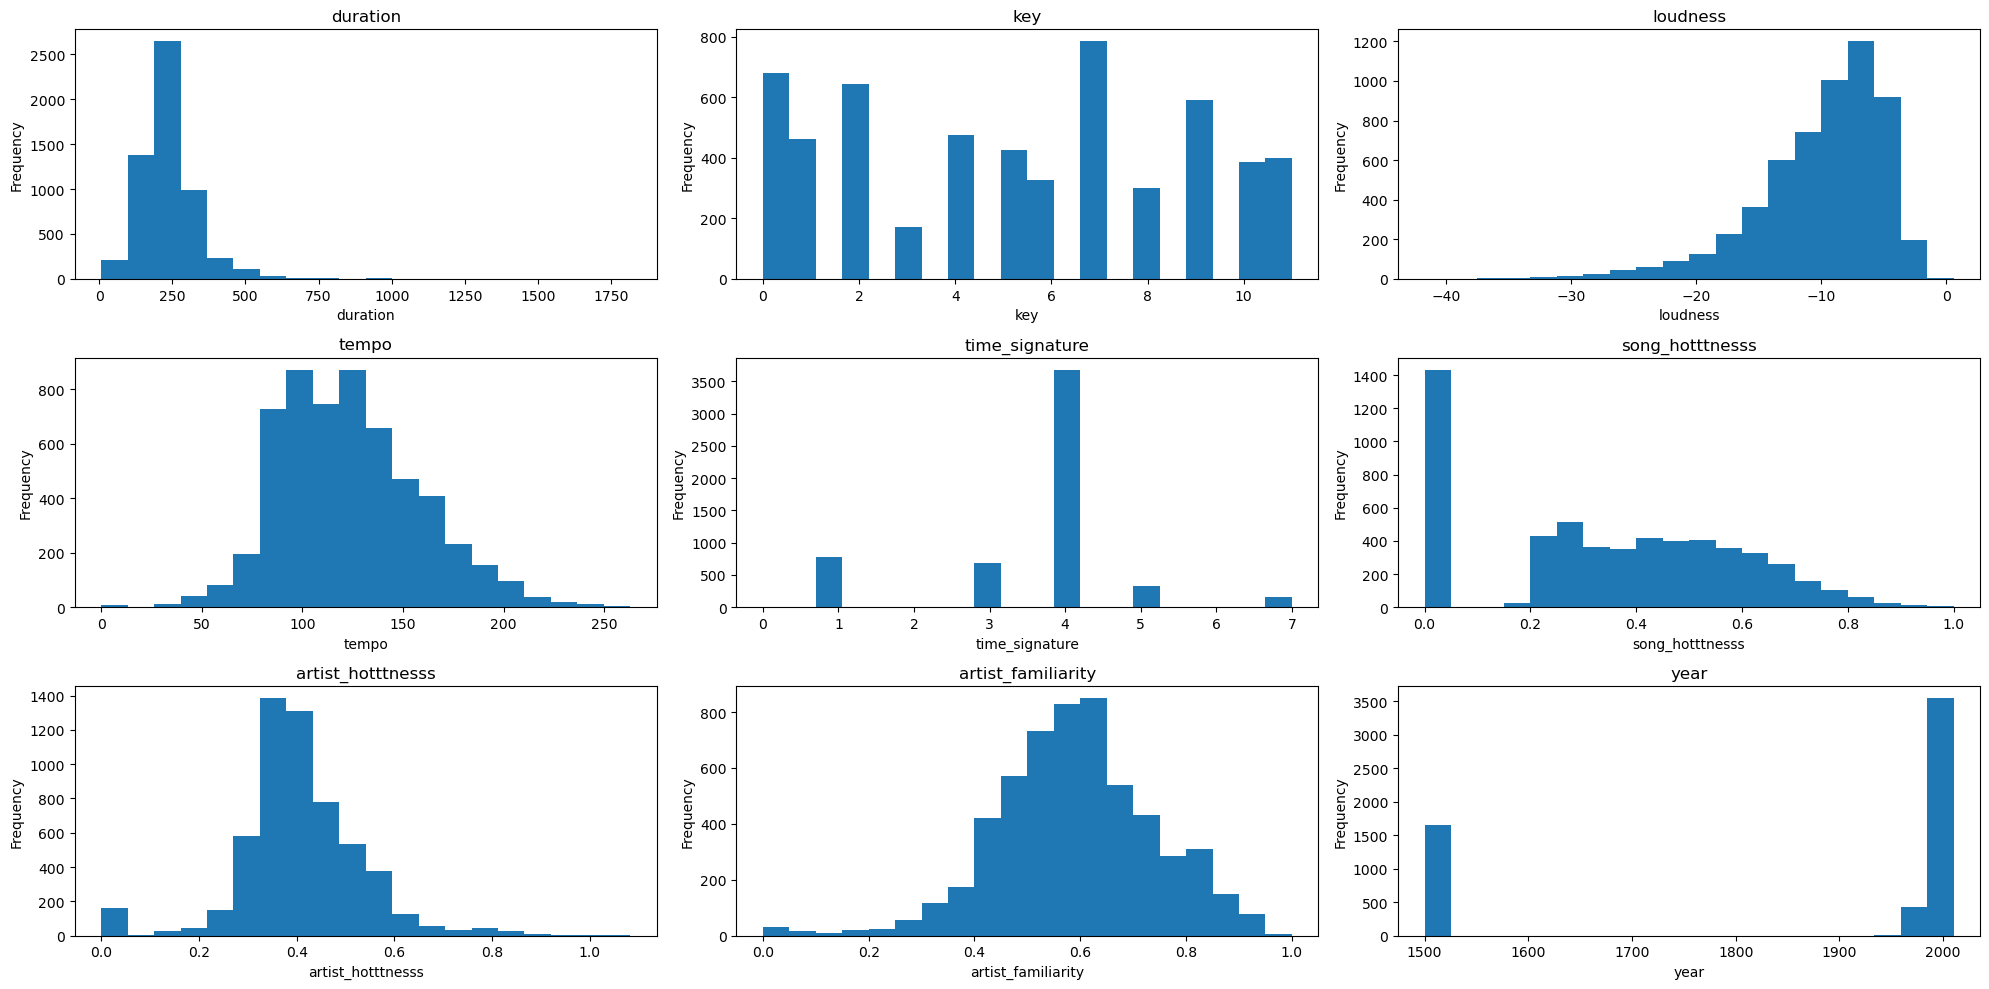

In [132]:
# Call the function of histogram and boxplot for the columns numeric functions
plot_histograms(data_MSD, numerical_cols)

In [45]:
#checkpoint
data_MSD2 = data_MSD

#  Standardization : 
##### - Standardardizer method: 

In [133]:
# standardize a column with IQR method
def standardize(df, column):
    lower, upper = 0.5, 0.75
    split_udf = udf(lambda x: float(list(x)[0].item()), DoubleType())
    
    # Create a VectorAssembler
    assembler = VectorAssembler(inputCols=[column], outputCol='temp')
    
    # Assemble the vector to the dataframe
    df = assembler.transform(df)
    
    # Define the RobustScaler
    scaler = RobustScaler(inputCol='temp', outputCol='stndr', withScaling=True, withCentering=False, lower=lower, upper=upper)
    
    # Compute summary statistics by fitting the RobustScaler
    scalerModel = scaler.fit(df)
    
    # Transform each column to have the unit quantile range
    df = scalerModel.transform(df)
    
    # Drop the created columns and substitute with the old column
    df = df.drop(column, 'temp')
    df = df.withColumn('stndr', split_udf(col('stndr')))
    df = df.withColumnRenamed('stndr', column)
    print("standardized : ", column)
    
    return df


##### Standardize following features:



In [134]:
numeric_columns = ['duration', 'loudness', 'tempo', 'song_hotttnesss', 'artist_hotttnesss', 'artist_familiarity']
standardized_df = data_MSD

for numeric_col in numeric_columns:
    standardized_df = standardize(standardized_df, numeric_col)

standardized :  duration
standardized :  loudness
standardized :  tempo
standardized :  song_hotttnesss
standardized :  artist_hotttnesss
standardized :  artist_familiarity


 #### Changes after Standardization: 

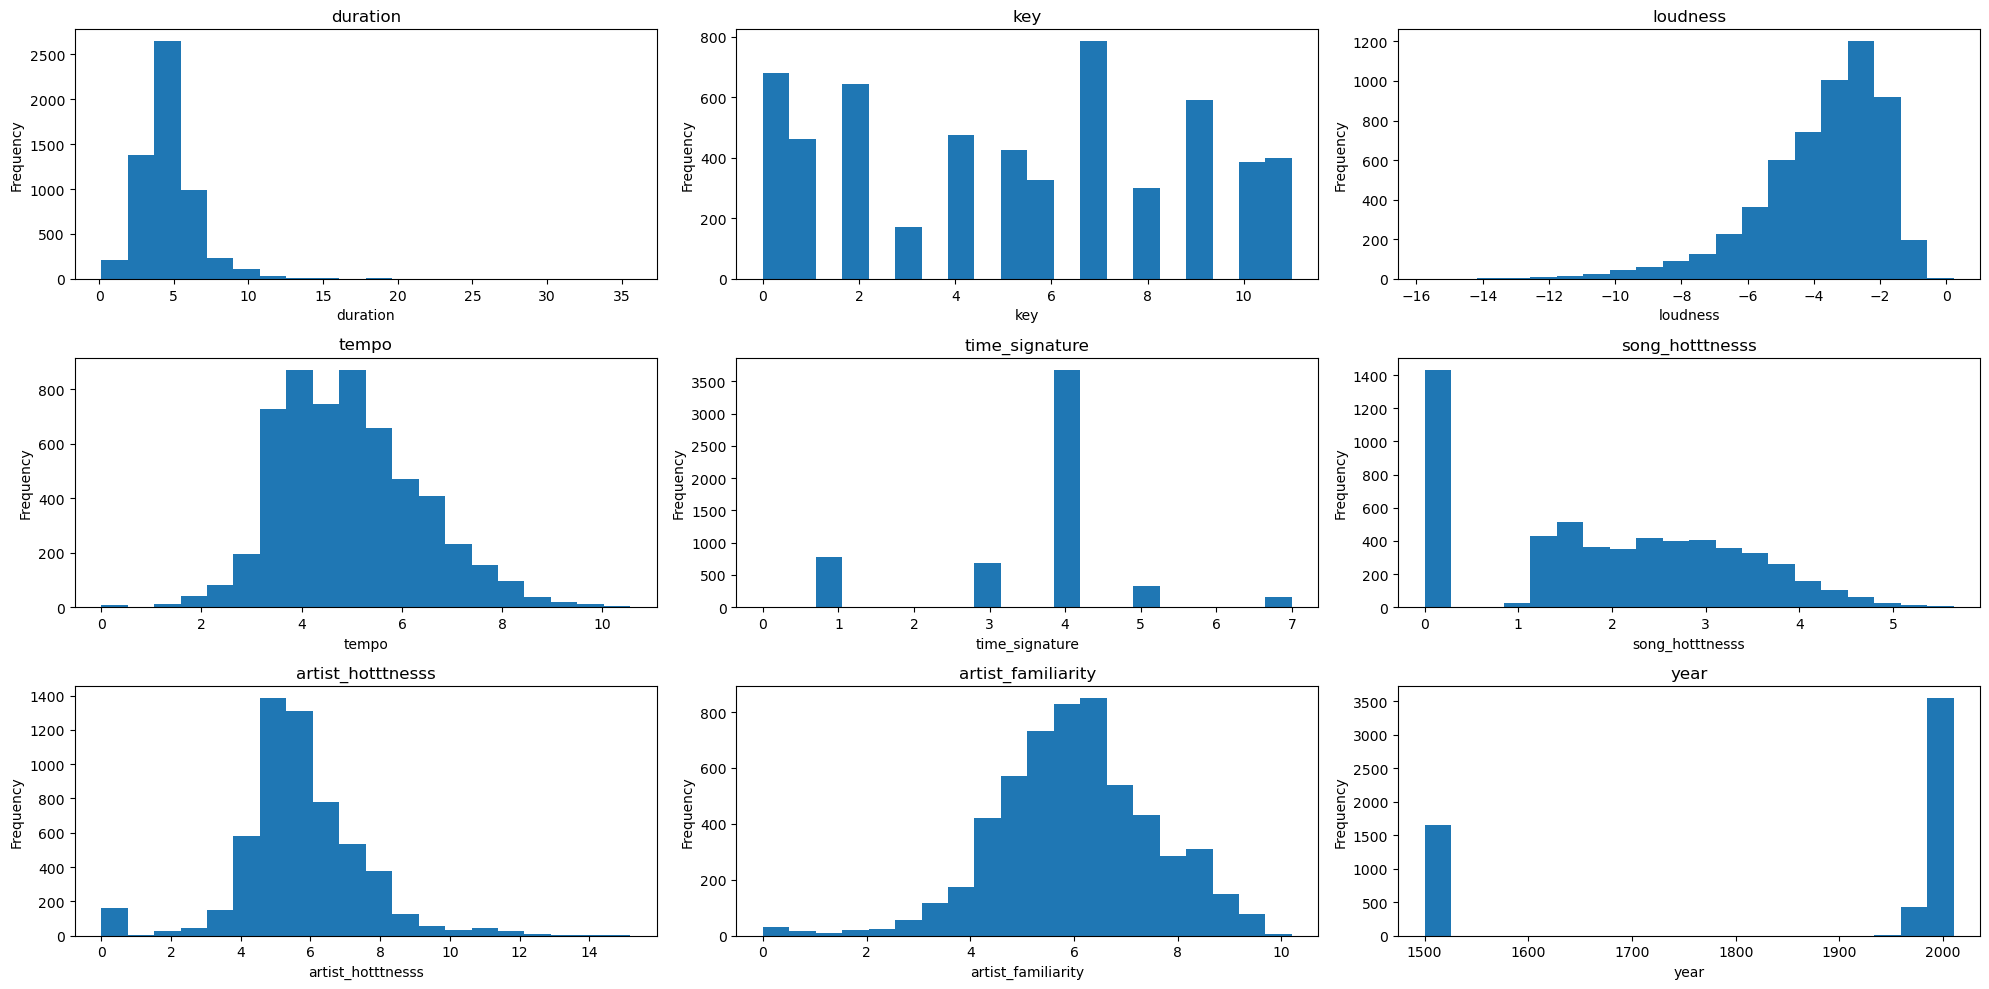

,0,1,2,3,4
summary,count,mean,stddev,min,max
artist_id,5647,None,None,AR00A6H1187FB5402A,ARZZRK91187B9A5CA5
song_id,5647,None,None,SOAAAQN12AB01856D3,SOZZWWW12A58A8146A
title,5647,1492.0,None,'Round the Wheel,Último Desejo
key,5647,5.262440233752435,3.5362367741891516,0,11
mode,5647,0.6936426421108554,0.4610207857236479,0,1
time_signature,5647,3.6010270940322293,1.2369126463052709,0,7
year,5647,1851.8712781001345,226.85176234645726,1500.0,2010.0
duration,5647,4.708518904892566,2.1727792891141573,0.13970459702819468,35.56242130449496
loudness,5647,-3.787262260841289,1.9537045032503302,-15.756234248472492,0.213907748422482


In [135]:
# Select only the numeric columns
numerical_cols = ['duration', 'key', 'loudness', 'tempo', 'time_signature', 
            'song_hotttnesss', 'artist_hotttnesss', 'artist_familiarity', 'year']
# Call the function
plot_histograms(standardized_df, numerical_cols)
# describe the dataset
standardized_df.describe().toPandas().T

#### 1.3.5 Store the scaled MSD dataset to a csv file

In [136]:
#data_MSD_scaled.write.mode("overwrite").csv('data_MSD_scaled.csv') error
#data_MSD_scaled.toPandas().to_csv("data_MSD_scaled1.csv", header=True)

msd_data= standardized_df

- Prepare the data
  - add index column instead of sring type columns

In [137]:
#to add index need to know the number of unique data in columns
unique_data(msd_data, ["artist_id", "song_id", "title"])

Number of unique values for each column, 
the total count is 5647
 
artist_id 2770
song_id 5647
title 5540


In [138]:
#Add index column for string column
# Since artist Id is not unique 
#Create a window specification to define the partitioning and ordering
window_spec = Window.orderBy('artist_id')
# Add a new column with the assigned index
msd_data = msd_data.withColumn('artist_index',dense_rank().over(window_spec))

# Add a new column with the assigned index
msd_data = msd_data.withColumn("song_index", monotonically_increasing_id())

# Convert title column to categorical feature
indexer_title = StringIndexer(inputCol='title', outputCol='title_indexed')
msd_data = indexer_title.fit(msd_data).transform(msd_data)

In [140]:
msd_data = standardize(msd_data, 'title_indexed')

standardized :  title_indexed


In [149]:
msd_data.columns

['song_id',
 'key',
 'mode',
 'time_signature',
 'year',
 'duration',
 'loudness',
 'tempo',
 'song_hotttnesss',
 'artist_hotttnesss',
 'artist_familiarity',
 'artist_id',
 'song_index',
 'title_indexed']

### Feature Importance based on songId

If you have a unique identifier for each song in your database (e.g., song_id), then it's true that the feature importance based on song_id alone may not be meaningful because it doesn't capture any variability in the data. However, there might still be other features in the dataset that can be used to determine the importance or relevance of a song. Therefore all the dataset will be stored.

In [147]:

def calculate_feature_importance(features, label, data):
    # Create a VectorAssembler to assemble the features into a vector column
    assembler = VectorAssembler(inputCols=features, outputCol='feature_vector')
    data = assembler.transform(data)



    # Create a RandomForestRegressor model
    rf = RandomForestRegressor(featuresCol='feature_vector', labelCol= label)

    # Fit the model to the data
    model = rf.fit(data)

    # Retrieve the feature importances
    importance = model.featureImportances

    # Create a dictionary to store the feature importance values
    feature_importance = {}

    # Retrieve the feature names and importance values
    feature_names = features
    for i, feature in enumerate(feature_names):
        feature_importance[feature] = importance[i]

    # Sort the features based on their importance
    sorted_importance = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)

    # Print the sorted list of features and their importance
    for feature, imp in sorted_importance:
        print(f"Feature: {feature}, Importance: {imp}")
    

In [151]:
features= ['key', 'mode','time_signature', 'year', 'duration', 'loudness', 'tempo', 'artist_hotttnesss',
 'artist_familiarity', 'artist_id', 'title_indexed','song_hotttnesss']

calculate_feature_importance(features, 'song_index', msd_data)

Feature: artist_id, Importance: 0.9764319657355097
Feature: artist_familiarity, Importance: 0.004342433782181059
Feature: artist_hotttnesss, Importance: 0.004274890890492771
Feature: duration, Importance: 0.002788009738998462
Feature: loudness, Importance: 0.0022206113309666997
Feature: year, Importance: 0.002157770116204075
Feature: title_indexed, Importance: 0.0018255865248493013
Feature: song_hotttnesss, Importance: 0.0017146023452299555
Feature: tempo, Importance: 0.0014180619051023266
Feature: time_signature, Importance: 0.0013738319114107744
Feature: key, Importance: 0.001054470183634999
Feature: mode, Importance: 0.0003977655354199922


### store data

In [153]:
# Specify the output path for the CSV files
output_path = 'Million_Song_data.csv'

# Coalesce the DataFrame to a single partition to minimize the number of output files
msd_df = msd_data.coalesce(1)

# Write the coalesced DataFrame to a CSV file
msd_df.write.csv(output_path, header=True, mode='overwrite')
